In [ ]:
import wellmap
import pandas as pd
import os
import string
import seaborn as sns
from os import listdir
from os.path import isfile, join

Old one for single images

In [ ]:
path_to_data = r"C:\Users\Modern\Documents\Biorad\CellProfiler\Results\2024-07-19 RD, Vero, hTERT CK-122\ExpWells_plate.csv"
path_to_wellmap = r"C:\Users\Modern\Documents\Biorad\CellProfiler\Results\2024-07-19 RD, Vero, hTERT CK-122\2024-07-19 RD CK-122 5H (Multichannel).toml"

data_raw = pd.read_csv(path_to_data) 

wellmap.show(path_to_wellmap)

print(data_raw.columns)
# print(data)


New for multiple images in CP file

In [ ]:
part_to_folder = r"C:\Users\Modern\Documents\Biorad\CellProfiler\Results\2024-07-19 RD, Vero, hTERT CK-122"

# files = [f for f in listdir(part_to_folder) if isfile(join(part_to_folder, f))]

image_list_path = os.path.join(part_to_folder, "ExpImage.csv")
data_path  = os.path.join(part_to_folder, "ExpWells_plate.csv")

data_raw_df = pd.read_csv(data_path) 
image_list_df = pd.read_csv(image_list_path) 

print(image_list_df)


Extract wellmaps and combine into one df with names of the images

In [ ]:
wellmap_path_list = []

for file in os.listdir(part_to_folder):
    if file.endswith(".toml"):
        wellmap_path_list.append(os.path.join(part_to_folder, file))
        # wellmap_path_list.append(file)

print(wellmap_path_list[0])

wellmap_df = wellmap.load(wellmap_path_list[0]) 

wellmap_list = []

for file in wellmap_path_list:
    wellmap_i = wellmap.load(file)
    wellmap_list.append(wellmap_i)

wellmaps_df = pd.concat(wellmap_list, axis=0, ignore_index=True)
print(wellmaps_df)

Generating labels for wells

In [ ]:
# row_column_df = pd.DataFrame(columns=['row','col'])

row =  list(string.ascii_uppercase[0:8])
column = list(range(1,13))
plate = image_list_df['FileName_RGB'].to_list()

row_column_list = []


for p in plate:
    for c in column:
        for r in row:
            array_i = [r,c]
            row_column_list.append(array_i)

row_column_df = pd.DataFrame(row_column_list, columns = ['row', 'col']) 

print(row_column_df)

In [ ]:
data = data_raw[['Intensity_IntegratedIntensity_OrigGreen','Intensity_IntegratedIntensity_OrigRed','Intensity_MeanIntensity_OrigGreen','Intensity_MeanIntensity_OrigRed']].copy()
data_indexed = pd.concat([row_column_df, data], axis=1, join='inner')


data_indexed['col']=data_indexed['col'].astype(str)


Add images names to data (thank you CellProfiler for convenience)

In [78]:
data_full_df =  pd.merge(data_raw_df, image_list_df, on='ImageNumber') #Data with image names (FileName_RGB)
data_indexed = pd.concat([row_column_df, data_full_df], axis=1, join='inner') #Data with image names (FileName_RGB) and cell indexes (row,col)

data_indexed['col']=data_indexed['col'].astype(str) #Otherwise everything will break

data_plate = pd.merge(data_indexed, wellmaps_df, on=['FileName_RGB','row','col']) #Data with image names (FileName_RGB), cell indexes and wellmap
data_plate[["conc_uM"]] = data_plate[["conc_uM"]].apply(pd.to_numeric)

print(data_plate.columns)

Index(['row', 'col', 'ImageNumber', 'ObjectNumber',
       'Intensity_IntegratedIntensity_OrigGreen',
       'Intensity_IntegratedIntensity_OrigRed',
       'Intensity_MeanIntensity_OrigGreen', 'Intensity_MeanIntensity_OrigRed',
       'Intensity_StdIntensity_OrigGreen', 'Intensity_StdIntensity_OrigRed',
       'FileName_RGB', 'well', 'well0', 'row_i', 'col_j', 'blank', 'conc_uM',
       'cells', 'uv', 'RZ_incubation', 'substance_incubation', 'culture_type'],
      dtype='object')


In [ ]:
#OBSOLETE

labels = wellmap.load(path_to_wellmap)
# print(labels.dtypes)
# print(data_indexed.dtypes)


data_plate = pd.merge(data_indexed, labels)
# print(labels.dtypes)

data_plate[["conc_uM"]] = data_plate[["conc_uM"]].apply(pd.to_numeric)

print(data_plate.dtypes)


Drop blank and outliers OLD

In [ ]:
#OBSOLETE

data_plate_wo_blank = data_plate[data_plate.blank == 'No'].copy()

well_drop_list = ['G12']

# data_plate_wo_blank = data_plate_wo_blank[~data_plate_wo_blank['well'].isin(well_drop_list)]

# df_show = data_plate_wo_blank.loc[(data_plate_wo_blank['sample'] == 'Substance_1') & (data_plate_wo_blank['conc_uM'] == '0')]

df_show = data_plate_wo_blank.loc[(data_plate_wo_blank['conc_uM'] == 0)]

print(df_show[['Intensity_MeanIntensity_OrigGreen','well']])

Relative values calculation OLD


In [ ]:
#OBSOLETE

blank_green = data_plate[(data_plate['blank'] == 'Yes')].loc[:,'Intensity_MeanIntensity_OrigGreen'].mean()

print(blank_green)

control_green = data_plate_wo_blank[(data_plate_wo_blank['conc_uM'] == 0)].loc[:,'Intensity_MeanIntensity_OrigGreen'].mean()

print(control_green)



data_plate_wo_blank['Green'] = data_plate_wo_blank['Intensity_MeanIntensity_OrigGreen'] - blank_green

data_plate_wo_blank['Green_relative'] = data_plate_wo_blank['Green']/control_green


df_show = data_plate_wo_blank.loc[(data_plate_wo_blank['conc_uM'] == 0)]

print(df_show[['Green_relative','well']])


Blank and control calculation for each plate

In [140]:
data_plate_wo_blank = data_plate[data_plate.blank == 'No'].copy() #dataframe without blank

blank_control_array = []

for p in plate:
    blank_p = data_plate[(data_plate['blank'] == 'Yes') & (data_plate['FileName_RGB'] == p)].loc[:,'Intensity_MeanIntensity_OrigGreen'].mean()
    control_p = data_plate_wo_blank[(data_plate['conc_uM'] == 0) & (data_plate_wo_blank['FileName_RGB'] == p)].loc[:,'Intensity_MeanIntensity_OrigGreen'].mean()
    bc_array_i = [blank_p,control_p,p]

    blank_control_array.append(bc_array_i)

print(blank_control_array)

blank_control_df = pd.DataFrame(blank_control_array, columns = ['blank', 'control','FileName_RGB']) 



[[0.0165215370057607, 0.15980326859442354, '2024-07-19 RD CK-122 5H (Multichannel).tif'], [0.016846963251064176, 0.18563342289145845, '2024-07-19 Vero CK-122 5H (Multichannel).tif'], [0.016796506465025826, 0.143160801819285, '2024-07-19 hTERT CK-122 5H (Multichannel).tif']]
      blank   control                                   FileName_RGB
0  0.016522  0.159803     2024-07-19 RD CK-122 5H (Multichannel).tif
1  0.016847  0.185633   2024-07-19 Vero CK-122 5H (Multichannel).tif
2  0.016797  0.143161  2024-07-19 hTERT CK-122 5H (Multichannel).tif


C:\Users\Modern\AppData\Local\Temp\ipykernel_8760\3219974335.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  control_p = data_plate_wo_blank[(data_plate['conc_uM'] == 0) & (data_plate_wo_blank['FileName_RGB'] == p)].loc[:,'Intensity_MeanIntensity_OrigGreen'].mean()
C:\Users\Modern\AppData\Local\Temp\ipykernel_8760\3219974335.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  control_p = data_plate_wo_blank[(data_plate['conc_uM'] == 0) & (data_plate_wo_blank['FileName_RGB'] == p)].loc[:,'Intensity_MeanIntensity_OrigGreen'].mean()
C:\Users\Modern\AppData\Local\Temp\ipykernel_8760\3219974335.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  control_p = data_plate_wo_blank[(data_plate['conc_uM'] == 0) & (data_plate_wo_blank['FileName_RGB'] == p)].loc[:,'Intensity_MeanIntensity_OrigGreen'].mean()


Relative values calculation 

In [110]:
for p in plate:
    blank_p = data_plate[(data_plate['blank'] == 'Yes') & (data_plate['FileName_RGB'] == p)].loc[:,'Intensity_MeanIntensity_OrigGreen'].mean()



0.0165215370057607
0.016846963251064176
0.016796506465025826


Plotting


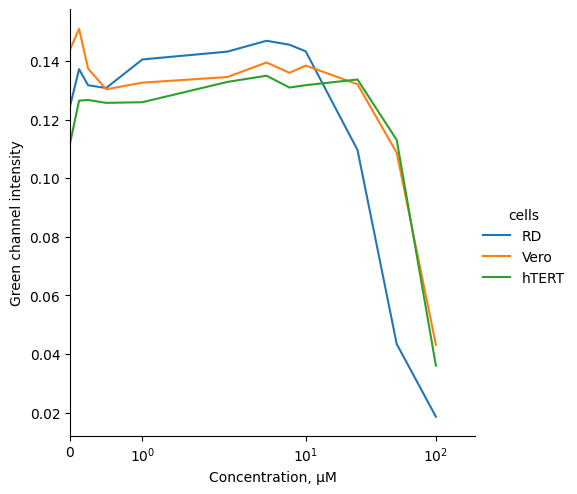

In [102]:
# sns.swarmplot(data=data_plate_wo_blank, x="conc_uM", y="Intensity_MeanIntensity_OrigGreen", hue='sample')
# ax = sns.scatterplot(data=data_plate_wo_blank, x="conc_uM", y="Intensity_MeanIntensity_OrigGreen")

ax = sns.relplot(data=data_plate, x="conc_uM", y="Intensity_MeanIntensity_OrigGreen", kind="line",  ci=None, hue = 'cells')


# ax.set(xlabel=None, ylabel='Viable cell, % of control')

ax.set(xlabel='Concentration, μM', ylabel='Green channel intensity')
ax.set(xscale="symlog")

ax.set(xlim=(0, 200))


# handles, labels = ax.get_legend_handles_labels()
# labels = ['CK-122','ISK-1','Control']
# ax.legend(handles=handles, labels=labels)

C:\Users\Modern\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\seaborn\categorical.py:1296: UserWarning: 8.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Modern\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\seaborn\categorical.py:1296: UserWarning: 12.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Modern\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\seaborn\categorical.py:1296: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Modern\AppData\Local\Packages

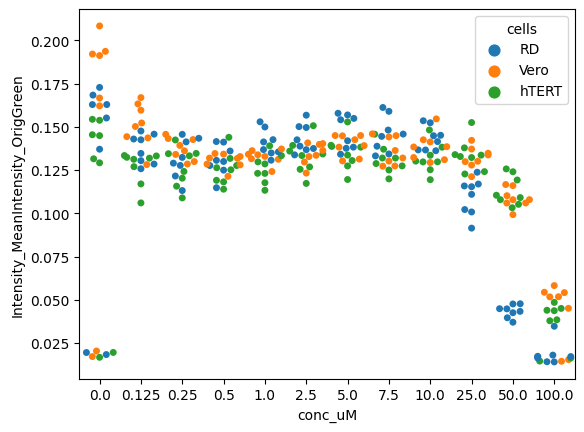

In [87]:
ax = sns.swarmplot(data=data_plate, x="conc_uM", y="Intensity_MeanIntensity_OrigGreen", hue = 'cells')
